## Table Of Contents: <a class="anchor" id="TableOfContents"></a>
* [Imports And Settings](#Imports)
* [Meta Functions](#Functions)
* [Spreadsheets](#Spreadsheets)
  * [Articles By Year](#ArticlesByYear)
* [Main DataFrame](#MainDataFrame) 
  * [Collapse](#Collapse)
  * [Confirm DataFrame](#ConfirmPrimary)
  * [Age Column](#AgeColumn)
  * [Age Group](#AgeGroup)
* [Final DataFrame](#FinalDataFrame) 
* [Combined Effects](#CombinedEffects) 
* [Stats_DataFrame](#StatsDataFrame) 
* [Analysis](#Analysis)

## Imports and Settings <a class="anchor" id="Imports"></a>

In [1]:

from scipy.stats import norm, ttest_ind, shapiro, normaltest, anderson, chisquare
from pandas.core.common import SettingWithCopyWarning
from IPython.display import display, Math, Latex
from scipy.optimize import minimize, curve_fit
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches                                                       # Figure Legends
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd
import numpy as np
import time as t0
import subprocess
import warnings
import copy

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

np.set_printoptions(threshold=np.inf, precision=3, linewidth=300, suppress=True)
np.seterr(divide='ignore', invalid='ignore')
pd.set_option('display.width'      , 1000, 
              'expand_frame_repr'  , False,
              'display.max_rows'   , 999,
              'display.max_columns', 999)

plt.rcParams["font.family" ] = "Myriad Pro"
plt.rcParams["pdf.fonttype"] = 42


## Meta Functions and Ratio Approximations <a class="anchor" id="Functions"></a>
 - [Return to Table of Contents](#TableOfContents)

In [2]:
from supp_functions import *

## Spreadsheets <a class="anchor" id="Spreadsheets"></a>

In [3]:
refname  = 'References_Concentrations.csv'
valname  = 'Values_Concentrations.csv'

dfR              = pd.read_csv('References_Concentrations.csv', encoding='latin')
dfR.Complete     = dfR.Complete.fillna('0')
dfR.Complete     = dfR.Complete.replace('X', '1')
dfR.Complete     = dfR.Complete.astype(int)

dfC              = pd.read_csv('Values_Concentrations.csv', encoding='latin')
dfC.ID           = dfC.ID.astype(int)
dfC              = dfC.fillna(0)
dfR.Control_ID   = dfR.Control_ID.astype(str)
dfR.Treatment    = dfR.Treatment.astype(str)

dfR              = dfR.fillna(0)
dfR['Year']      = dfR['Reference'].astype(str).str[:4]

dfR_             = dfR[dfR.Complete == 1].reset_index(drop=True)

dfR = copy.deepcopy(dfR_)

article_cntrl  = list(sorted(set(dfR.Reference)))
article_cntrl.remove('2021_coughlin_26')
print('Creating Primary DataFrame')
print('    Unique Articles: {:3d}'.format(len(article_cntrl)))
print('    Total Groups   : {:3d}'.format(dfR.shape[0]))


Creating Primary DataFrame
    Unique Articles: 350
    Total Groups   : 2553


## Number of Articles By Year <a class="anchor" id="ArticlesByYear"></a>

In [4]:
def breakdown(dfR, dfR_):
    dfR_Control   = dfR_[~dfR_.Control_ID.str.contains('No Control')].reset_index(drop=True)
    dfR_Treat     = dfR_[ dfR_.Treatment.str.contains( '1'         )].reset_index(drop=True)
    dfR_Control   = pd.concat([dfR_Control, dfR_Treat]).reset_index(drop=True)

    years         = ['2017', '2018', '2019', '2020', '2021']
    years.reverse()

    tesla         = list(set(dfR_Control.Tesla))

    for ii in range(len(years)):
        dfRYear       = dfR[ dfR.Year  == years[ii]].reset_index(drop=True)
        dfR_Year      = dfR_[dfR_.Year == years[ii]].reset_index(drop=True)
        dfR_Year_Cnrl = dfR_Control[dfR_Control.Year == years[ii]].reset_index(drop=True)

        article_total = list(sorted(set(dfRYear.Reference)))
        article_cmplt = list(sorted(set(dfR_Year.Reference)))
        article_cntrl = list(sorted(set(dfR_Year_Cnrl.Reference)))

        print('\n{:5d} Articles          : {:3d}'.format(int(years[ii]), len(article_total)))
        print('{:5d} Articles Completed: {:3d}   {:.2f}%'.format(int(years[ii]), len(article_cmplt), 100*len(article_cmplt)/len(article_total)))
        print('{:5d} Articles w/Control: {:3d}'.format(int(years[ii]), len(article_cntrl)))

    dfRYear       = dfR[ dfR.Year.astype(int)  < 2017].reset_index(drop=True)
    dfR_Year      = dfR_[dfR_.Year.astype(int) < 2017].reset_index(drop=True)
    dfR_Year_Cnrl = dfR_Control[dfR_Control.Year.astype(int) < 2017].reset_index(drop=True)

    article_total = list(sorted(set(dfRYear.Reference)))
    article_cmplt = list(sorted(set(dfR_Year.Reference)))
    article_cntrl = list(sorted(set(dfR_Year_Cnrl.Reference)))

    print('\n<2017 Articles          : {:3d}'.format(len(article_total)))
    print('<2017 Articles Completed: {:3d}   {:.2f}%'.format(len(article_cmplt), 100*len(article_cmplt)/len(article_total)))
    print('<2017 Articles w/Control: {:3d}'.format(len(article_cntrl)))

breakdown(dfR, dfR_)


 2021 Articles          :  66
 2021 Articles Completed:  66   100.00%
 2021 Articles w/Control:  46

 2020 Articles          :  67
 2020 Articles Completed:  67   100.00%
 2020 Articles w/Control:  53

 2019 Articles          :  85
 2019 Articles Completed:  85   100.00%
 2019 Articles w/Control:  64

 2018 Articles          : 103
 2018 Articles Completed: 103   100.00%
 2018 Articles w/Control:  73

 2017 Articles          :  15
 2017 Articles Completed:  15   100.00%
 2017 Articles w/Control:  14

<2017 Articles          :  15
<2017 Articles Completed:  15   100.00%
<2017 Articles w/Control:   9


## Create Main DataFrame <a class="anchor" id="MainDataFrame"></a>
 - [Return to Table of Contents](#TableOfContents)

In [5]:

df_main             = pd.DataFrame()
for ii in range(len(article_cntrl)):

    dfC_current     = dfC[dfC.Reference.str.contains(article_cntrl[ii])].reset_index(drop=True)

    dfR_current     = dfR[dfR.Reference.str.contains(article_cntrl[ii])].reset_index(drop=True)    
    dfR_current0    = dfR_current[dfR_current.Group.str.contains('Control')].reset_index(drop=True)
    dfR_current1    = dfR_current[dfR_current.Group.str.contains('Healthy')].reset_index(drop=True)
    dfR_current2    = dfR_current[dfR_current.Group.str.contains('Aged')   ].reset_index(drop=True)
    dfR_current3    = dfR_current[dfR_current.Group.str.contains('Preterm')].reset_index(drop=True)
    dfR_current_    = pd.concat([dfR_current0, dfR_current1, dfR_current2, dfR_current3])

    print('{:3d} {:<14}  |  {:3d} {:3d} {:3d} {:3d}| Total {:3d}'.format(ii, article_cntrl[ii][:14], 
                                                                     dfR_current0.shape[0], 
                                                                     dfR_current1.shape[0], 
                                                                     dfR_current2.shape[0],
                                                                     dfR_current3.shape[0],
                                                                     dfR_current_.shape[0]))

    dfR_current_.ID = dfR_current_.ID.astype(int)   
    idxs            = list(dfR_current_.ID)

    for jj in range(len(idxs)):        
        dfR_current_control = dfR_current[ dfR_current.ID  == idxs[jj]].reset_index(drop=True)
        dfC_current_control = dfC_current[ dfC_current.ID  == idxs[jj]].reset_index(drop=True)

        metabs_     = list(set(dfC_current_control.Name))

        for kk in range(len(metabs_)):
            try:
                dfC_current_control_ = dfC_current_control[dfC_current_control.Name == metabs_[kk]].reset_index(drop=True)                                
                dfR_current_kk       = copy.deepcopy(dfR_current_control)
                dfR_current_kk['Metabolite'] = metabs_[kk]

                if int(dfR_current_control['N_Exclusions' ][0]) == 0:
                    dfR_current_kk['Healthy_N'  ] = int(dfR_current_control['N_Total'     ][0])
                else:
                    dfR_current_kk['Healthy_N'  ] = int(dfR_current_control['N_Exclusions'][0])

                dfR_current_kk['Healthy_Cr_u'   ] = float(dfC_current_control_['tCr_u'  ][0])
                dfR_current_kk['Healthy_Cr_std' ] = float(dfC_current_control_['tCr_std'][0])
                dfR_current_kk['Healthy_IU_u'   ] = float(dfC_current_control_['IU_u'   ][0])
                dfR_current_kk['Healthy_IU_std' ] = float(dfC_current_control_['IU_std' ][0])
                dfR_current_kk['Healthy_mM_u'   ] = float(dfC_current_control_['mM_u'   ][0])
                dfR_current_kk['Healthy_mM_std' ] = float(dfC_current_control_['mM_std' ][0])

                confidence_intervals_Cr           = conf_from_stats(dfR_current_kk['Healthy_Cr_u'  ][0], 
                                                                    dfR_current_kk['Healthy_Cr_std'][0],
                                                                    dfR_current_kk['Healthy_N'     ][0],)

                confidence_intervals_IU           = conf_from_stats(dfR_current_kk['Healthy_IU_u'  ][0], 
                                                                    dfR_current_kk['Healthy_IU_std'][0],
                                                                    dfR_current_kk['Healthy_N'     ][0],)

                confidence_intervals_mM           = conf_from_stats(dfR_current_kk['Healthy_mM_u'  ][0], 
                                                                    dfR_current_kk['Healthy_mM_std'][0],
                                                                    dfR_current_kk['Healthy_N'     ][0],)

                dfR_current_kk['Healthy_Cr_Low' ] = confidence_intervals_Cr[0]
                dfR_current_kk['Healthy_Cr_Hgh' ] = confidence_intervals_Cr[1]
                dfR_current_kk['Healthy_IU_Low' ] = confidence_intervals_IU[0]
                dfR_current_kk['Healthy_IU_Hgh' ] = confidence_intervals_IU[1]
                dfR_current_kk['Healthy_mM_Low' ] = confidence_intervals_mM[0]
                dfR_current_kk['Healthy_mM_Hgh' ] = confidence_intervals_mM[1]

                to_add      = np.nanmean(np.array([
                                         dfR_current_kk['Healthy_Cr_u'][0], 
                                         dfR_current_kk['Healthy_IU_u'][0],
                                         dfR_current_kk['Healthy_mM_u'][0]
                                                  ]))
                if np.isnan(to_add) == False:
                    df_main = pd.concat([df_main, dfR_current_kk])

            except Exception as e:
                print(e)

df_main = df_main.reset_index(drop=True)


  0 2008_shih_28    |    0   5   0   0| Total   5
  1 2010_terpstra_  |    0  10   0   0| Total  10
  2 2014_gomar_75   |    6   0   0   0| Total   6
  3 2015_calderon-  |    8   0   0   0| Total   8
  4 2015_glodzik_4  |    2   0   0   0| Total   2
  5 2015_guo_15     |    0   0   0   0| Total   0
  6 2015_seraji-bo  |    2   0   0   0| Total   2
  7 2015_simoes_21  |    1   0   0   0| Total   1
  8 2015_snoussi_7  |    0   4   0   0| Total   4
  9 2016_deelchand  |    0   3   0   0| Total   3
 10 2016_guo_69     |    4   0   0   0| Total   4
 11 2016_howells_3  |    6   0   0   0| Total   6
 12 2016_koob_11    |    2   0   0   2| Total   4
 13 2016_mazuel_27  |    1   0   0   0| Total   1
 14 2016_wu_206     |    0   0   0   0| Total   0
 15 2017_atagun_63  |    2   0   0   0| Total   2
 16 2017_barbagall  |    6   0   0   0| Total   6
 17 2017_brennan_2  |    1   0   0   0| Total   1
 18 2017_cao_42     |    4   0   0   0| Total   4
 19 2017_carlson_3  |    2   0   0   0| Total   2


## Collapse MM and IU values into the IU columns <a class="anchor" id="Collapse"></a>

In [6]:
df_main.Healthy_IU_u   = df_main.Healthy_IU_u.values   + df_main.Healthy_mM_u.values
df_main.Healthy_IU_std = df_main.Healthy_IU_std.values + df_main.Healthy_mM_std.values

## Confirm Primary DataFrame <a class="anchor" id="ConfirmPrimary"></a>

In [7]:

def confirm_dataframe(df, reference):
    print('Groups within DataFrame: ', list(sorted(set(df_main.Group))))
    print(' ')
    display(df_main[df_main.Reference.str.contains(reference)].reset_index(drop=True)[['Reference', 'Group', 'ID', 'Metabolite', 'Voxel_Region', 'Left/Right/Both', 'Healthy_Cr_u', 'Healthy_mM_u', 'Healthy_IU_u']])

confirm_dataframe(df_main, '2020_macmaster_35') # '2019_meyer_10'

Groups within DataFrame:  ['Aged', 'Control', 'Healthy', 'Preterm']
 


,Reference,Group,ID,Metabolite,Voxel_Region,Left/Right/Both,Healthy_Cr_u,Healthy_mM_u,Healthy_IU_u
0,2020_macmaster_35,Control,1.0,NAA,DLPFC,Right,0.0,11.05,11.05
1,2020_macmaster_35,Control,1.0,Cre,DLPFC,Right,0.0,6.30,6.30
2,2020_macmaster_35,Control,1.0,Glx,DLPFC,Right,0.0,12.83,12.83
3,2020_macmaster_35,Control,1.0,Myo,DLPFC,Right,0.0,5.10,5.10
4,2020_macmaster_35,Control,1.0,GPC,DLPFC,Right,0.0,1.67,1.67
5,2020_macmaster_35,Control,5.0,NAA,DLPFC,Left,0.0,11.20,11.20
6,2020_macmaster_35,Control,5.0,Cre,DLPFC,Left,0.0,6.46,6.46
7,2020_macmaster_35,Control,5.0,Glx,DLPFC,Left,0.0,13.28,13.28
8,2020_macmaster_35,Control,5.0,Myo,DLPFC,Left,0.0,5.28,5.28
9,2020_macmaster_35,Control,5.0,GPC,DLPFC,Left,0.0,1.79,1.79


## Age Column <a class="anchor" id="AgeColumn"></a>

In [8]:

def make_age_column(df,):
    
    age_ranges    = np.arange(0, 100)
    age_ranges[0] = 0.001
    ages          = []

    print('DataFrame Initial Shape: ', df.shape)

    for ii in range(df.shape[0]):
        app     = 0

        try:    
            age = float(df.Age[ii])
            for jj in range(1, age_ranges.shape[0]):
                if app == 0:
                    if age == 0:
                        ages.append('NA')
                        app = 1

                    elif age >= age_ranges[jj-1] and age < age_ranges[jj]:
                        ages.append(age_ranges[jj-1])
                        app = 1

            if app == 0:
                print(df.Reference[ii], df_main.Age[ii])
        except:
            ages.append(30)
            print(df.Reference[ii], df_main.Age[ii])
    
    df['Age_Order'] = ages
    print('DataFrame Final Shape  : ', df.shape)

    return df

df_main  = make_age_column(df_main)

DataFrame Initial Shape:  (4046, 73)
DataFrame Final Shape  :  (4046, 74)


## Separate Adolescent, Young, and Aged Subjects <a class="anchor" id="AgeGroup"></a>

In [9]:
df_main['Age_Order_num'] = df_main.Age_Order.astype(int)

df_inft = df_main[df_main.Age_Order_num < 2 ].reset_index(drop=True)

df_adol = df_main[df_main.Age_Order_num > 5 ].reset_index(drop=True)
df_adol = df_adol[df_adol.Age_Order_num < 15].reset_index(drop=True)

df_aged = df_main[df_main.Age_Order_num > 50].reset_index(drop=True)

df_norm = df_main[df_main.Age_Order_num > 18].reset_index(drop=True)
df_norm = df_norm[df_norm.Age_Order_num < 45].reset_index(drop=True)
   
print('Full  : {:4d} articles with {:5d} rows'.format(len(list(set(df_main.Reference))), df_main.shape[0]))
print(' ')
print('Infant: {:4d} articles with {:5d} rows'.format(len(list(set(df_inft.Reference))), df_inft.shape[0]))
print('Adol. : {:4d} articles with {:5d} rows'.format(len(list(set(df_adol.Reference))), df_adol.shape[0]))
print('Young : {:4d} articles with {:5d} rows'.format(len(list(set(df_norm.Reference))), df_norm.shape[0]))
print('Aging : {:4d} articles with {:5d} rows'.format(len(list(set(df_aged.Reference))), df_aged.shape[0]))


Full  :  285 articles with  4046 rows
 
Infant:    9 articles with   161 rows
Adol. :   20 articles with   362 rows
Young :  205 articles with  2876 rows
Aging :   45 articles with   468 rows


## Create Final DataFrame <a class="anchor" id="FinalDataFrame"></a>
 - [Return to Table of Contents](#TableOfContents)

In [10]:

def final_dataframe(df_main, metabolite):
    ignore      = ['2019_meyer_10', '2018_sheth_276', '2018_sivaraman_281', '2019_girgis_275','2020_sheth_123', ] 
    screen      = ['2018_galinska-skok_2018', '2018_karczewska-kupczewska_103', '2018_atagun_235', '2018_veeramuthu_25', '2016_koob_11']
    df_final0   = df_main[df_main.Metabolite == metabolite].reset_index(drop=True)
    df_final0   = df_final0[df_final0.Treatment.astype(int) == 0].reset_index(drop=True)
    df_final0   = df_final0.sort_values(by=['Age_Order', 'Metabolite', 'Reference'], ascending=False).reset_index(drop=True)
    
    cols        = ['Healthy_mM'    , 'Healthy_IU'    , 'Healthy_Cr'    ]
    dfs         = [pd.DataFrame({}), pd.DataFrame({}), pd.DataFrame({})]
    cnts        = np.zeros([3])
    
    for jj in range(len(cols)):
        mx_val  = np.max(df_final0['{}_u'.format(cols[jj])])
        
        for ii in range(df_final0.shape[0]):     
            
            df_final1    = df_final0[df_final0.Reference == df_final0.Reference[ii]].reset_index(drop=True)
            df_final1    = df_final1[df_final1.ID == df_final0.ID[ii]].reset_index(drop=True)

            if df_final1.shape[0] == 1:  
                u        = df_final1['{}_u'.format(cols[jj])][0]
                u       /= mx_val                                                           # Normalize Values to 1
                std      = df_final1['{}_std'.format(cols[jj])][0]
                std     /= mx_val                                                           # Normalize Values to 1
                
                if u > .001 and std > .001:
                    
                    var  = std**2
                    wgt  = 1/var
                    ucol = '{}_u'.format(  cols[jj])
                    scol = '{}_std'.format(cols[jj])
                    vcol = '{}_Var'.format(cols[jj])
                    wcol = '{}_Wgt'.format(cols[jj])
                    mcol = '{}_Max'.format(cols[jj])
                    
                    df_final1[ucol] = copy.deepcopy(u  )
                    df_final1[scol] = copy.deepcopy(std)
                    df_final1[vcol] = copy.deepcopy(var)
                    df_final1[wcol] = copy.deepcopy(wgt)
                    df_final1[mcol] = mx_val

                    if df_final1.Reference[0] not in ignore and df_final1.Reference[0] not in screen: # Skip - See Reference Notes
                        dfs[ jj]  = pd.concat([dfs[jj], df_final1])
                        cnts[jj] += 1
                    elif df_final1.Reference[0] in screen:
                        if jj != 1:
                            dfs[ jj]  = pd.concat([dfs[jj], df_final1])
                            cnts[jj] += 1                            
            else:
                print('\n >1: ')
                display(df_final1)
                        
    return dfs, cnts


## Combined Effects <a class="anchor" id="CombinedEffects"></a>
 - [Return to Table of Contents](#TableOfContents)

In [18]:
def get_combined_effects(mdict_metab):
    mdict_metab['Effects'] = {'Healthy_mM': {},
                              'Healthy_IU': {},
                              'Healthy_Cr': {}}
    Ekeys     = list(mdict_metab['Effects'].keys())
    
    empty_    = {'M'      : 0.0,
                 'Var'    : 0.0,
                 'SE'     : 0.0,
                 'Z'      : 0.0,
                 'P-1Tail': 1.0,
                 'P-2Tail': 1.0,
                 'Weight' : 0.0,
                 'Low'    : 0.0,
                 'Hgh'    : 0.0,
                 'Q'      : 0.0,
                 'I2'     : 0.0}
    
    for ii in range(len(Ekeys)):
        ustr  = '{}_u'.format(  Ekeys[ii])
        wstr  = '{}_Wgt'.format(Ekeys[ii])
                
        try:
            fix = fixed_effect( mdict_metab['DataFrame'][ii], Tcol=ustr, Wcol=wstr)
            mdict_metab['Effects'][Ekeys[ii]]['Fixed_Effect' ] = fix
        except Exception as e:
            mdict_metab['Effects'][Ekeys[ii]]['Fixed_Effect' ] = copy.deepcopy(empty_)

        try:
            ran = random_effect(mdict_metab['DataFrame'][ii], Tcol=ustr, Wcol=wstr)
            mdict_metab['Effects'][Ekeys[ii]]['Random_Effect'] = ran
        except Exception as e:
            mdict_metab['Effects'][Ekeys[ii]]['Random_Effect'] = copy.deepcopy(empty_)

    return mdict_metab

## Stats DataFrame <a class="anchor" id="StatsDataFrame"></a> 
  - [Return to Table of Contents](#TableOfContents)

In [20]:
def stats_dataframe(df_main, metabs, effect='RandomEffect'):
    
    mdict        = {}
    for ii in range(len(metabs)):
        mdict[metabs[ii]] = {}
        
    df_stats     = pd.DataFrame({})

    for ii in range(len(metabs)):
        dfs,cnts = final_dataframe(df_main, metabs[ii])
        
        mdict[metabs[ii]]['DataFrame'] = copy.deepcopy(dfs)
        mdict[metabs[ii]]['Counts'   ] = copy.deepcopy(cnts)
        mdict[metabs[ii]]              = get_combined_effects(mdict[metabs[ii]])
        
        ## Move Everything to an Organized DataFrame for Convenience
        mm = metabs[ii]
        df_stats0 = pd.DataFrame({})
        df_stats0['Metabolite'] = [mm]
        df_stats0['mM_u'      ] = [mdict[mm]['Effects']['Healthy_mM']['Fixed_Effect']['M'  ]]
        df_stats0['mM_low'    ] = [mdict[mm]['Effects']['Healthy_mM']['Fixed_Effect']['Low']]
        df_stats0['mM_hgh'    ] = [mdict[mm]['Effects']['Healthy_mM']['Fixed_Effect']['Hgh']]
        df_stats0['mM_N'      ] = mdict[metabs[ii]]['DataFrame'][0].shape[0]
        df_stats0['IU_u'      ] = [mdict[mm]['Effects']['Healthy_IU']['Fixed_Effect']['M'  ]]
        df_stats0['IU_low'    ] = [mdict[mm]['Effects']['Healthy_IU']['Fixed_Effect']['Low']]
        df_stats0['IU_hgh'    ] = [mdict[mm]['Effects']['Healthy_IU']['Fixed_Effect']['Hgh']]
        df_stats0['IU_N'      ] = mdict[metabs[ii]]['DataFrame'][1].shape[0]
        df_stats0['Cr_u'      ] = [mdict[mm]['Effects']['Healthy_Cr']['Fixed_Effect']['M'  ]]
        df_stats0['Cr_low'    ] = [mdict[mm]['Effects']['Healthy_Cr']['Fixed_Effect']['Low']]
        df_stats0['Cr_hgh'    ] = [mdict[mm]['Effects']['Healthy_Cr']['Fixed_Effect']['Hgh']]
        df_stats0['Cr_N'      ] = mdict[metabs[ii]]['DataFrame'][2].shape[0]
        df_stats0['Effect'    ] = 'Fixed'
        df_stats                = pd.concat([df_stats, df_stats0])

        df_stats1 = pd.DataFrame({})
        df_stats1['Metabolite'] = [mm]
        df_stats1['mM_u'      ] = [mdict[mm]['Effects']['Healthy_mM']['Random_Effect']['M'  ]]
        df_stats1['mM_low'    ] = [mdict[mm]['Effects']['Healthy_mM']['Random_Effect']['Low']]
        df_stats1['mM_hgh'    ] = [mdict[mm]['Effects']['Healthy_mM']['Random_Effect']['Hgh']]
        df_stats1['mM_I2'     ] = [mdict[mm]['Effects']['Healthy_mM']['Random_Effect']['I2' ]]
        df_stats1['mM_N'      ] = mdict[metabs[ii]]['DataFrame'][0].shape[0]
        df_stats1['IU_u'      ] = [mdict[mm]['Effects']['Healthy_IU']['Random_Effect']['M'  ]]
        df_stats1['IU_low'    ] = [mdict[mm]['Effects']['Healthy_IU']['Random_Effect']['Low']]
        df_stats1['IU_hgh'    ] = [mdict[mm]['Effects']['Healthy_IU']['Random_Effect']['Hgh']]
        df_stats1['IU_I2'     ] = [mdict[mm]['Effects']['Healthy_IU']['Random_Effect']['I2' ]]
        df_stats1['IU_N'      ] = mdict[metabs[ii]]['DataFrame'][1].shape[0]
        df_stats1['Cr_u'      ] = [mdict[mm]['Effects']['Healthy_Cr']['Random_Effect']['M'  ]]
        df_stats1['Cr_low'    ] = [mdict[mm]['Effects']['Healthy_Cr']['Random_Effect']['Low']]
        df_stats1['Cr_hgh'    ] = [mdict[mm]['Effects']['Healthy_Cr']['Random_Effect']['Hgh']]
        df_stats1['Cr_I2'     ] = [mdict[mm]['Effects']['Healthy_Cr']['Random_Effect']['I2' ]]
        df_stats1['Cr_N'      ] = mdict[metabs[ii]]['DataFrame'][2].shape[0]
        df_stats1['Effect'    ] = 'Random'
        df_stats                = pd.concat([df_stats, df_stats1])
          
        if df_stats1['mM_I2'].values[0] <= 0:
            df_stats1['mM_I2'].values[0] = np.nan
        if df_stats1['IU_I2'].values[0] <= 0:
            df_stats1['IU_I2'].values[0] = np.nan
        if df_stats1['Cr_I2'].values[0] <= 0:
            df_stats1['Cr_I2'].values[0] = np.nan

        print('{:<4} Complete  |  mM: {:3d} ({:6.2f}%)  |  IU: {:3d} ({:6.2f}%)  |  Cr: {:3d} ({:6.2f}%)'.format(
                                                                          metabs[ii][:4], 
                                                                          mdict[metabs[ii]]['DataFrame'][0].shape[0],
                                                                          df_stats1['mM_I2'].values[0],
                                                                          mdict[metabs[ii]]['DataFrame'][1].shape[0],
                                                                          df_stats1['IU_I2'].values[0],
                                                                          mdict[metabs[ii]]['DataFrame'][2].shape[0],
                                                                          df_stats1['Cr_I2'].values[0]))

    return df_stats, mdict

## Analysis <a class="anchor" id="Analysis"></a> 
  - [Return to Table of Contents](#TableOfContents)

In [25]:
metabs = ['Ala', 'Asc', 'Asp', 'Cre', 'tCr', 'GPC', 'tCho', 'GABA', 'Glc', 'Gln', 'Glu', 'Gly', 'Glx', 'GSH', 'Lac', 'Myo', 'NAA', 'PE', 'tNAA', 'NAAG', 'Scy', 'Tau']

print('Infant {:<16} N      I2 {:<12} N      I2  {:<12} N     I2'.format(' ', ' ', ' '))
stats_df_inft,mdict_inft = stats_dataframe(df_inft, metabs)
print(' ')
print('Adolescent {:<19} N  I2 {:<11} N  I2  {:<11} N I2'.format(' ', ' ', ' '))
stats_df_adol,mdict_adol = stats_dataframe(df_adol, metabs)
print(' ')
print('Young {:<19} N  I2 {:<11} N  I2  {:<11} N I2'.format(' ', ' ', ' '))
stats_df_norm,mdict_norm = stats_dataframe(df_norm, metabs)
print(' ')
print('Aged {:<19} N  I2 {:<11} N  I2  {:<11} N I2'.format(' ', ' ', ' '))
stats_df_aged,mdict_aged = stats_dataframe(df_aged, metabs)


Infant                  N      I2              N      I2               N     I2
Ala  Complete  |  mM:   0 (   nan%)  |  IU:   0 (   nan%)  |  Cr:   0 (   nan%)
Asc  Complete  |  mM:   0 (   nan%)  |  IU:   0 (   nan%)  |  Cr:   0 (   nan%)
Asp  Complete  |  mM:   0 (   nan%)  |  IU:   0 (   nan%)  |  Cr:   0 (   nan%)
Cre  Complete  |  mM:   0 (   nan%)  |  IU:   5 (  1.06%)  |  Cr:   2 (   nan%)
tCr  Complete  |  mM:   6 (   nan%)  |  IU:   7 (   nan%)  |  Cr:   0 (   nan%)
GPC  Complete  |  mM:   0 (   nan%)  |  IU:   5 ( 55.30%)  |  Cr:   5 ( 86.80%)
tCho Complete  |  mM:   8 ( 64.30%)  |  IU:   9 ( 65.96%)  |  Cr:   7 (   nan%)
GABA Complete  |  mM:   0 (   nan%)  |  IU:   5 ( 62.18%)  |  Cr:   5 (   nan%)
Glc  Complete  |  mM:   0 (   nan%)  |  IU:   0 (   nan%)  |  Cr:   0 (   nan%)
Gln  Complete  |  mM:   0 (   nan%)  |  IU:   0 (   nan%)  |  Cr:   0 (   nan%)
Glu  Complete  |  mM:   7 (   nan%)  |  IU:  17 ( 74.25%)  |  Cr:   9 ( 84.78%)
Gly  Complete  |  mM:   0 (   nan%)  |  

## Citations

In [128]:
mkeys    = list(mdict_norm.keys())
df_refs  = pd.DataFrame({})

for ii in range(len(mkeys)):
    for jj in range(3):
                            
        df_ref0 = mdict_norm[mkeys[ii]]['DataFrame'][jj]
        if df_ref0.shape[0] > 0:
            df_ref0 = df_ref0[['Reference', 'DOI', 'Title']]
            df_ref0['Norm'] = np.ones([ df_ref0.shape[0]])
            df_ref0['Aged'] = np.zeros([df_ref0.shape[0]])
            df_ref0['Inft'] = np.zeros([df_ref0.shape[0]])
            df_ref0['Adol'] = np.zeros([df_ref0.shape[0]])

        df_ref1 = mdict_aged[mkeys[ii]]['DataFrame'][jj]
        if df_ref1.shape[0] > 0:
            df_ref1 = df_ref1[['Reference', 'DOI', 'Title']]
            df_ref1['Norm'] = np.zeros([df_ref1.shape[0]])
            df_ref1['Aged'] = np.ones([ df_ref1.shape[0]])
            df_ref1['Inft'] = np.zeros([df_ref1.shape[0]])
            df_ref1['Adol'] = np.zeros([df_ref1.shape[0]])

        df_ref2 = mdict_inft[mkeys[ii]]['DataFrame'][jj]
        if df_ref2.shape[0] > 0:
            df_ref2 = df_ref2[['Reference', 'DOI', 'Title']]        
            df_ref2['Norm'] = np.zeros([df_ref2.shape[0]])
            df_ref2['Aged'] = np.zeros([df_ref2.shape[0]])
            df_ref2['Inft'] = np.ones([ df_ref2.shape[0]])
            df_ref2['Adol'] = np.zeros([df_ref2.shape[0]])
        
        df_ref3 = mdict_adol[mkeys[ii]]['DataFrame'][jj]
        if df_ref3.shape[0] > 0:
            df_ref3 = df_ref3[['Reference', 'DOI', 'Title']]
            df_ref3['Norm'] = np.zeros([df_ref3.shape[0]])
            df_ref3['Aged'] = np.zeros([df_ref3.shape[0]])
            df_ref3['Inft'] = np.zeros([df_ref3.shape[0]])
            df_ref3['Adol'] = np.ones([ df_ref3.shape[0]])
              
        ref_totals = (df_ref0.shape[0] + df_ref1.shape[0] + df_ref2.shape[0] + df_ref3.shape[0])
        print('{:<4} {:3d} {:3d} {:3d} {:3d} | Total = {:3d}'.format(mkeys[ii][:4], df_ref0.shape[0], df_ref1.shape[0], df_ref2.shape[0], df_ref3.shape[0], ref_totals))

        df_refs = pd.concat([df_refs, df_ref0, df_ref1, df_ref2, df_ref3])
            
df_refs  = df_refs.reset_index(drop=True)
df_refs_ = pd.DataFrame({})

all_refs = list(set(df_refs.Reference))
for ii in range(len(all_refs)):
    
    all_refs_ = df_refs[df_refs.Reference == all_refs[ii]].reset_index(drop=True)
    if np.sum(all_refs_.Norm) > 0:
        all_refs_.Norm.values[:] = np.ones([all_refs_.shape[0]])
    if np.sum(all_refs_.Aged) > 0:
        all_refs_.Aged.values[:] = np.ones([all_refs_.shape[0]])
    if np.sum(all_refs_.Inft) > 0:
        all_refs_.Inft.values[:] = np.ones([all_refs_.shape[0]])
    if np.sum(all_refs_.Adol) > 0:
        all_refs_.Adol.values[:] = np.ones([all_refs_.shape[0]])

    df_refs_ = pd.concat([df_refs_, all_refs_.head(1)])

age_cols = ['Norm', 'Aged', 'Inft', 'Adol']
df_refs_.to_csv('Citations_Healthy_All.csv')

print(' ')
print('Unique Pubs: {:3d}'.format(len(list(set(df_refs_.Reference)))))
print('Unique DOIs: {:3d}'.format(len(list(set(df_refs_.DOI      )))))

print(' ')
for ii in range(len(age_cols)):
    df_refs_spec = df_refs_[df_refs_[age_cols[ii]] == 1].reset_index(drop=True)
    
    print('{} Total = {:3d}'.format(age_cols[ii], df_refs_spec.shape[0]))
    df_refs_spec.to_csv('Citations_Healthy_{}.csv'.format(age_cols[ii]))


Ala    0   0   0   0 | Total =   0
Ala    2   0   0   0 | Total =   2
Ala    0   0   0   0 | Total =   0
Asc    3   7   0   0 | Total =  10
Asc   18   7   0   0 | Total =  25
Asc    4   0   0   0 | Total =   4
Asp   11   6   0   0 | Total =  17
Asp   30   6   0   0 | Total =  36
Asp    5   3   0   0 | Total =   8
Cre   36   1   0   3 | Total =  40
Cre   95  13   5   3 | Total = 116
Cre   11   0   2   0 | Total =  13
tCr   54  20   6  15 | Total =  95
tCr  202  32   7  32 | Total = 273
tCr    0   0   0   0 | Total =   0
GPC   36   7   0  14 | Total =  57
GPC   84  18   5  16 | Total = 123
GPC   49  14   5   8 | Total =  76
tCho  32  12   8   2 | Total =  54
tCho 153  24   9  20 | Total = 206
tCho 172  22   7  48 | Total = 249
GABA  72   7   0   1 | Total =  80
GABA 209  13   5   5 | Total = 232
GABA  54   6   5   2 | Total =  67
Glc    1   0   0   0 | Total =   1
Glc    2   0   0   0 | Total =   2
Glc    1   3   0   0 | Total =   4
Gln   35  11   0   0 | Total =  46
Gln   86  11   0   0

## Start Analysis

In [26]:
metabs    = ['Ala', 'Asc', 'Asp', 'Cre', 'tCr', 'GPC', 'tCho', 'GABA', 'Glc', 'Gln', 'Glu', 'Gly', 'Glx', 'GSH', 'Lac', 'Myo', 'NAA', 'PE', 'tNAA', 'NAAG', 'Scy', 'Tau']

cols      = ['mM_u','mM_low','mM_hgh','IU_u','IU_low','IU_hgh','Cr_u','Cr_low','Cr_hgh','All_u','All_low','All_hgh']
cols      = ['mM_u','IU_u','Cr_u']

stats_dfs = [stats_df_norm, stats_df_aged]

mnew      = pd.DataFrame({})
mnew['Metabolite']  = stats_df_norm['Metabolite']
mnew['Effect'    ]  = stats_df_norm['Effect'    ]
mnew['Inft_IU'    ] = stats_df_inft['IU_u'      ]
mnew['Inft_IU_L'  ] = stats_df_inft['IU_low'    ]
mnew['Inft_IU_H'  ] = stats_df_inft['IU_hgh'    ]
mnew['Adol_IU'    ] = stats_df_adol['IU_u'      ]
mnew['Adol_IU_L'  ] = stats_df_adol['IU_low'    ]
mnew['Adol_IU_H'  ] = stats_df_adol['IU_hgh'    ]
mnew['Norm_IU'    ] = stats_df_norm['IU_u'      ]
mnew['Norm_IU_L'  ] = stats_df_norm['IU_low'    ]
mnew['Norm_IU_H'  ] = stats_df_norm['IU_hgh'    ]
mnew['Norm_IU_H'  ] = stats_df_norm['IU_hgh'    ]
mnew['Aged_IU'    ] = stats_df_aged['IU_u'      ]
mnew['Aged_IU_L'  ] = stats_df_aged['IU_low'    ]
mnew['Aged_IU_H'  ] = stats_df_aged['IU_hgh'    ]
mnew['Aged_IU_Max'] = stats_df_aged['IU_hgh'    ]
mnew['Norm_IU'    ] = stats_df_norm['IU_u'      ]
mnew['Norm_IU_L'  ] = stats_df_norm['IU_low'    ]
mnew['Norm_IU_H'  ] = stats_df_norm['IU_hgh'    ]
mnew['Norm_IU_N'  ] = stats_df_norm['IU_N'      ]
mnew['Aged_IU'    ] = stats_df_aged['IU_u'      ]
mnew['Aged_IU_L'  ] = stats_df_aged['IU_low'    ]
mnew['Aged_IU_H'  ] = stats_df_aged['IU_hgh'    ]
mnew['Aged_IU_N'  ] = stats_df_aged['IU_N'      ]
mnew['Inft_IU'    ] = stats_df_inft['IU_u'      ]
mnew['Inft_IU_L'  ] = stats_df_inft['IU_low'    ]
mnew['Inft_IU_H'  ] = stats_df_inft['IU_hgh'    ]
mnew['Inft_IU_N'  ] = stats_df_inft['IU_N'      ]
mnew['Adol_IU'    ] = stats_df_adol['IU_u'      ]
mnew['Adol_IU_L'  ] = stats_df_adol['IU_low'    ]
mnew['Adol_IU_H'  ] = stats_df_adol['IU_hgh'    ]
mnew['Adol_IU_N'  ] = stats_df_adol['IU_N'      ]
mnew['Norm_Cr'    ] = stats_df_norm['Cr_u'      ]
mnew['Norm_Cr_L'  ] = stats_df_norm['Cr_low'    ]
mnew['Norm_Cr_H'  ] = stats_df_norm['Cr_hgh'    ]
mnew['Norm_Cr_N'  ] = stats_df_norm['Cr_N'      ]
mnew['Aged_Cr'    ] = stats_df_aged['Cr_u'      ]
mnew['Aged_Cr_L'  ] = stats_df_aged['Cr_low'    ]
mnew['Aged_Cr_H'  ] = stats_df_aged['Cr_hgh'    ]
mnew['Aged_Cr_N'  ] = stats_df_aged['Cr_N'      ]
mnew['Inft_Cr'    ] = stats_df_inft['Cr_u'      ]
mnew['Inft_Cr_L'  ] = stats_df_inft['Cr_low'    ]
mnew['Inft_Cr_H'  ] = stats_df_inft['Cr_hgh'    ]
mnew['Inft_Cr_N'  ] = stats_df_inft['Cr_N'      ]
mnew['Adol_Cr'    ] = stats_df_adol['Cr_u'      ]
mnew['Adol_Cr_L'  ] = stats_df_adol['Cr_low'    ]
mnew['Adol_Cr_H'  ] = stats_df_adol['Cr_hgh'    ]
mnew['Adol_Cr_N'  ] = stats_df_adol['Cr_N'      ]

display(mnew)


,Metabolite,Effect,Inft_IU,Inft_IU_L,Inft_IU_H,Adol_IU,Adol_IU_L,Adol_IU_H,Norm_IU,Norm_IU_L,Norm_IU_H,Aged_IU,Aged_IU_L,Aged_IU_H,Aged_IU_Max,Norm_IU_N,Aged_IU_N,Inft_IU_N,Adol_IU_N,Norm_Cr,Norm_Cr_L,Norm_Cr_H,Norm_Cr_N,Aged_Cr,Aged_Cr_L,Aged_Cr_H,Aged_Cr_N,Inft_Cr,Inft_Cr_L,Inft_Cr_H,Inft_Cr_N,Adol_Cr,Adol_Cr_L,Adol_Cr_H,Adol_Cr_N
0,Ala,Fixed,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.932444,0.804443,1.060444,0.000000,0.000000,0.000000,0.000000,2,0,0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
0,Ala,Random,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.619634,-0.180205,1.419473,0.000000,0.000000,0.000000,0.000000,2,0,0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
0,Asc,Fixed,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.272853,0.265645,0.280060,0.599635,0.528446,0.670824,0.670824,18,7,0,0,0.925216,0.804233,1.046199,4,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
0,Asc,Random,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.386558,0.337107,0.436010,0.599783,0.520942,0.678623,0.678623,18,7,0,0,0.948891,NaN,NaN,4,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
0,Asp,Fixed,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.338480,0.315794,0.361165,0.571006,0.481783,0.660230,0.660230,30,6,0,0,0.332375,0.311281,0.353469,5,0.975531,0.909439,1.041623,3,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
0,Asp,Random,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.448801,0.375678,0.521925,0.557289,0.507518,0.607060,0.607060,30,6,0,0,0.484393,0.324692,0.644093,5,0.971420,0.949453,0.993387,3,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
0,Cre,Fixed,0.948634,0.916475,0.980792,0.308978,0.276775,0.341182,0.271321,0.266235,0.276408,0.692521,0.643015,0.742027,0.742027,95,13,5,3,0.500451,0.481567,0.519334,11,0.000000,0.000000,0.000000,0,0.980769,0.820854,1.140684,2,0.000000,0.000000,0.000000,0
0,Cre,Random,0.948895,0.912457,0.985334,0.580224,0.143456,1.016993,0.363029,0.334836,0.391222,0.745618,0.651694,0.839542,0.839542,95,13,5,3,0.520818,0.475544,0.566092,11,0.000000,0.000000,0.000000,0,0.980769,0.943077,1.018462,2,0.000000,0.000000,0.000000,0
0,tCr,Fixed,0.639801,0.555465,0.724138,0.076751,0.073798,0.079704,0.368312,0.366093,0.370532,0.688639,0.670012,0.707265,0.707265,202,32,7,32,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0
0,tCr,Random,0.633235,NaN,NaN,0.101868,0.090215,0.113522,0.431497,0.417596,0.445397,0.696452,0.634842,0.758062,0.758062,202,32,7,32,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0


## Figure With Overlaid Scatter Plot

Asc  Cr  Norm: Fix: 0.9252 0.8042 1.0462  |  Ran: 0.9489    nan    nan
Gly  Cr  Norm: Fix: 0.9371 0.6406 1.2336  |  Ran: 0.7273    nan    nan


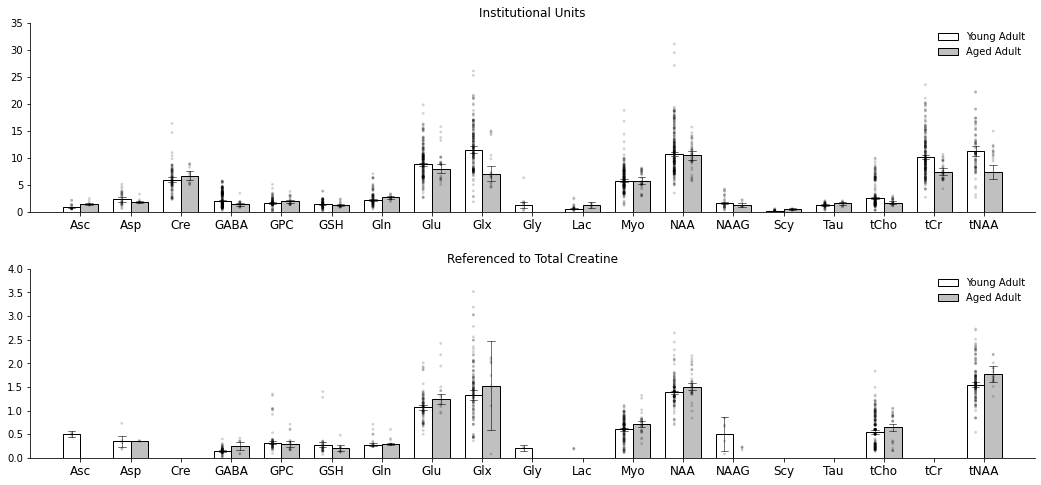

In [53]:
mnew_  = mnew[['Metabolite', 'Effect',
               'Norm_Cr', 'Norm_Cr_L', 'Norm_Cr_H', 'Aged_Cr', 'Aged_Cr_L', 'Aged_Cr_H',
               'Norm_IU', 'Norm_IU_L', 'Norm_IU_H', 'Aged_IU', 'Aged_IU_L', 'Aged_IU_H']]
mets   = list(sorted(set(mnew_.Metabolite)))
mets.remove('PE')
mets.remove('Ala')
mets.remove('Glc')

units  = [ 'mM', 'IU', 'Cr' ] 
grps   = ['Norm', 'Aged']
xloc   = [-0.175  , 0.175 ]
mdicts = [mdict_norm, mdict_aged]

cm     = 1/2.54
# fig,ax = plt.subplots(2,1, figsize=(88*cm/10, 44*cm/10))
fig,ax = plt.subplots(2,1, figsize=(18, 8))

for ii in range(1,len(units)):
    for jj in range(len(grps)):
        for kk in range(len(mets)):

            v    = mdicts[jj][mets[kk]]['DataFrame'][ii]
            if v.shape[0] >= 2:
                mx    = v['Healthy_{}_Max'.format(units[ii])].values[0]
                v     = copy.deepcopy(v['Healthy_{}_u'.format(  units[ii])].values)
                v    *= mx
                ones  = np.ones([v.shape[0]]) * kk
                ones += xloc[jj]
            
                cmb = mdicts[jj][mets[kk]]['DataFrame'][ii]

                mnew_mt  = mnew_[mnew_.Metabolite == mets[kk]].reset_index(drop=True)
                ran      = mdicts[jj][mets[kk]]['Effects']['Healthy_{}'.format(units[ii])]['Random_Effect']
                fix      = mdicts[jj][mets[kk]]['Effects']['Healthy_{}'.format(units[ii])][ 'Fixed_Effect']
                ast      = ''
                
                if np.abs(ran['M']) > .0001 and np.isnan(np.mean(np.array([ran['M'], ran['Low'], ran['Hgh']]))) == False:
                    comb_effect = copy.deepcopy(ran)
                    effect = 'Random'
                else:
                    comb_effect = copy.deepcopy(fix)
                    print('{:<4} {}  {:<4}: Fix: {:6.4f} {:6.4f} {:6.4f}  |  Ran: {:6.4f} {:6.4f} {:6.4f}'.format(mets[kk][:4], units[ii], grps[jj][:4], fix['M'], fix['Low'], fix['Hgh'], ran['M'], ran['Low'], ran['Hgh']))
                    effect = 'Fixed'
                    ast = '*'
                    
                u    = comb_effect['M']
                u   *= mx
                lw   = comb_effect['Low']
                lw  *= mx
                hg   = comb_effect['Hgh']
                hg  *= mx

                std  = (hg - lw)/ 3.92 * np.sqrt(cmb.shape[0])

                skp  = 0
                if ii == 2:
                    if mets[kk] == 'Cre' or mets[kk] == 'tCr':
                        skp = 1

                if u > .0001 and lw > .0001:
                    x = kk + xloc[jj]
                    if jj == 0 and skp == 0:
                        ax[ii-1].bar(x, u, width=.35, facecolor='white', edgecolor='k', linewidth=1.0, zorder=5)
                        ax[ii-1].plot([x, x], [lw, hg],           color='k', linewidth=.55, zorder=10)
                        ax[ii-1].plot([x-.075, x+.075], [lw, lw], color='k', linewidth=.55, zorder=10)
                        ax[ii-1].plot([x-.075, x+.075], [hg, hg], color='k', linewidth=.55, zorder=10)
                        ax[ii-1].scatter(ones, v, color='k', alpha=.175    , edgecolors='none', zorder=25, s=8)
                    elif jj == 1 and skp == 0:
                        ax[ii-1].bar(x, u, width=.35, facecolor='silver', edgecolor='k', linewidth=1.0, zorder=5)
                        ax[ii-1].plot([x, x], [lw, hg],           color='k', linewidth=.55, zorder=10)
                        ax[ii-1].plot([x-.075, x+.075], [lw, lw], color='k', linewidth=.55, zorder=10)
                        ax[ii-1].plot([x-.075, x+.075], [hg, hg], color='k', linewidth=.55, zorder=10)
                        ax[ii-1].scatter(ones, v, color='k', alpha=.175    , edgecolors='none', zorder=25, s=8)
                else:
                    x = kk + xloc[jj]
                    if jj == 0 and skp == 0:
                        ax[ii-1].scatter(ones, v, color='k', alpha=.175    , edgecolors='none', zorder=25, s=8)
                    elif jj == 1 and skp == 0:
                        ax[ii-1].scatter(ones, v, color='k', alpha=.175    , edgecolors='none', zorder=25, s=8)
                    
ax[0].set_xticks([x for x in range(0, len(mets))]) 
ax[0].set_xticklabels(mets, fontsize=12)
ax[0].set_xlim([-1, len(mets)])
ax[1].set_xticks([x for x in range(0, len(mets))]) 
ax[1].set_xticklabels(mets, fontsize=12)
ax[1].set_xlim([-1, len(mets)])
    
ax[1].set_ylim([0.0,  4.00])
ax[0].set_ylim([0.0, 35.00])

ax[1].set_title('Referenced to Total Creatine', fontweight=12)
ax[0].set_title('Institutional Units', fontweight=12)

black = mpatches.Patch(facecolor='white' , edgecolor='k', label='Young Adult') 
grey  = mpatches.Patch(facecolor='silver', edgecolor='k', label='Aged Adult') 
ax[0].legend(handles=[black, grey], loc=1, frameon=False) 
ax[1].legend(handles=[black, grey], loc=1, frameon=False) 

ax[0].spines['top'   ].set_visible(False)
ax[0].spines['right' ].set_visible(False)
ax[1].spines['top'   ].set_visible(False)
ax[1].spines['right' ].set_visible(False)

ax[0].xaxis.set_tick_params(width=.80)
ax[0].yaxis.set_tick_params(width=.80)
ax[1].xaxis.set_tick_params(width=.80)
ax[1].yaxis.set_tick_params(width=.80)

plt.subplots_adjust(hspace = .3)
# plt.show()
plt.savefig('Figure_Healthy_Populations.pdf', dpi=300, transparent=True)

## Output All Resulting Metabolite Values from Each Group

In [51]:
mnew_  = mnew[['Metabolite', 'Effect',
               'Norm_Cr', 'Norm_Cr_L', 'Norm_Cr_H', 'Aged_Cr', 'Aged_Cr_L', 'Aged_Cr_H',
               'Norm_IU', 'Norm_IU_L', 'Norm_IU_H', 'Aged_IU', 'Aged_IU_L', 'Aged_IU_H']]
mets   = list(sorted(set(mnew_.Metabolite)))
mets.remove('PE')
mets.remove('Ala')
mets.remove('Glc')

units  = [ 'mM', 'IU', 'Cr' ] 
grps   = ['Inft', 'Adol', 'Norm', 'Aged']
mdicts = [mdict_inft, mdict_adol, mdict_norm, mdict_aged]

df_units = []
df_grp   = []
df_n     = []
df_mets  = []
df_us    = []
df_std   = []
df_low   = []
df_hgh   = []
df_eff   = []

for ii in range(1,len(units)):
    for jj in range(len(grps)):
        for kk in range(len(mets)):

            v    = mdicts[jj][mets[kk]]['DataFrame'][ii]
            if v.shape[0] >= 2:
                mx    = v['Healthy_{}_Max'.format(units[ii])].values[0]           

                mnew_mt  = mnew_[mnew_.Metabolite == mets[kk]].reset_index(drop=True)
                ran      = mdicts[jj][mets[kk]]['Effects']['Healthy_{}'.format(units[ii])]['Random_Effect']
                fix      = mdicts[jj][mets[kk]]['Effects']['Healthy_{}'.format(units[ii])][ 'Fixed_Effect']
                ast      = ''
                
                if np.abs(ran['M']) > .0001 and np.isnan(np.mean(np.array([ran['M'], ran['Low'], ran['Hgh']]))) == False:
                    comb_effect = copy.deepcopy(ran)
                    effect = 'Random'
                else:
                    comb_effect = copy.deepcopy(fix)
                    print('{:<4} {}  {:<4}: Fix: {:6.4f} {:6.4f} {:6.4f}  |  Ran: {:6.4f} {:6.4f} {:6.4f}'.format(mets[kk][:4], units[ii], grps[jj][:4], fix['M'], fix['Low'], fix['Hgh'], ran['M'], ran['Low'], ran['Hgh']))
                    effect = 'Fixed'
                    ast = '*'
                    
                u    = comb_effect['M']
                u   *= mx
                lw   = comb_effect['Low']
                lw  *= mx
                hg   = comb_effect['Hgh']
                hg  *= mx

                std  = (hg - lw)/ 3.92 * np.sqrt(v.shape[0])

                skp  = 0
                if ii == 2:
                    if mets[kk] == 'Cre' or mets[kk] == 'tCr':
                        skp = 1

                if u > .0001 and lw > .0001:
                    if skp == 0:
                        df_units.append(units[ii])
                        df_grp.append(grps[jj])
                        df_n.append(v.shape[0])
                        df_mets.append(mets[kk])
                        df_us.append(u)
                        df_std.append(std)
                        df_low.append(lw)
                        df_hgh.append(hg)
                        df_eff.append(effect)
                        
df_vals = pd.DataFrame({'Metabolite': df_mets,
                        'Units'     : df_units,
                        'Groups'    : df_grp,
                        'N'         : df_n,
                        'Mean'      : df_us,
                        'StdDev'    : df_std,
                        'CI_Low'    : df_low,
                        'CI_High'   : df_hgh,
                        'Effect'    : df_eff})
                    
# df_vals.to_csv('Values_Concentration_RandomEffects_Simulations.csv')


Myo  IU  Inft: Fix: 0.3838 0.3706 0.3970  |  Ran: 0.3877    nan    nan
tCr  IU  Inft: Fix: 0.6398 0.5555 0.7241  |  Ran: 0.6332    nan    nan
GABA IU  Adol: Fix: 0.8690 0.7413 0.9967  |  Ran: 0.7980    nan    nan
GSH  Cr  Inft: Fix: 0.8215 0.6290 1.0139  |  Ran: 0.6338    nan    nan
Glx  Cr  Inft: Fix: 0.8633 0.7306 0.9961  |  Ran: 0.4709    nan    nan
GABA Cr  Adol: Fix: 0.7453 0.3373 1.1532  |  Ran: 0.6429    nan    nan
GSH  Cr  Adol: Fix: 1.0000 0.8960 1.1040  |  Ran: 1.0000    nan    nan
Lac  Cr  Adol: Fix: 0.7396 0.5546 0.9247  |  Ran: 0.8605    nan    nan
Asc  Cr  Norm: Fix: 0.9252 0.8042 1.0462  |  Ran: 0.9489    nan    nan
Gly  Cr  Norm: Fix: 0.9371 0.6406 1.2336  |  Ran: 0.7273    nan    nan


## Comparison of Results vs. Published Estimates

0 Asc
1 Asp
2 Cre
3 GABA
4 GPC
5 GSH
6 Glc
7 Gln
8 Glu
9 Glx
10 Gly
11 Lac
12 Myo
13 NAA
14 NAAG
15 PCh
16 PCr
17 PE
18 Scy
19 Tau
20 tCho
21 tCr
22 tNAA


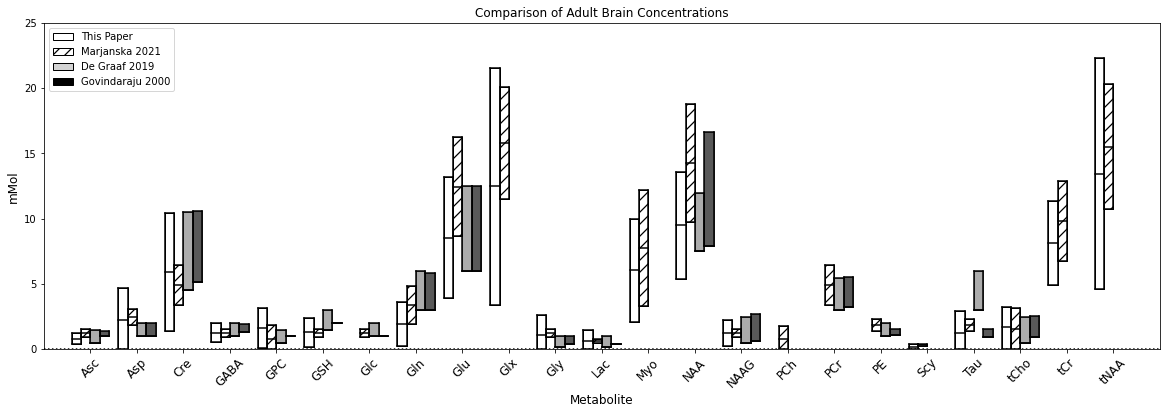

In [44]:
df   = pd.read_csv('Gudmundson_vs_Fit_Values.csv')
DG   = pd.read_csv('C:/Users/agudm/Desktop/degraaf_concentrations.csv')
DGv  = pd.read_csv('C:/Users/agudm/Desktop/Govindaraju_concentrations.csv')

mets = list(sorted(set(df.Metabolite)))
grps = ['G', 'F', 'D', 'Gov']
loc0 = [-0.4, -0.2, 0.0, 0.2]
loc1 = [-0.2, -0.0, 0.2, 0.4]
hatc = [None, '//', None, None]

ymin = 0
ymax = 25

colors = ['white', 'white', 'grey', 'k']

fig, ax = plt.subplots(figsize=(20,6))
ax.set_ylim([ymin, ymax])

for ii in range(len(mets)):
    print(ii, mets[ii])
    df_  = df[df.Metabolite == mets[ii]]
    DG_  = DG[DG.Metabolite == mets[ii]]
    DGv_ = DGv[DGv.Metabolite == mets[ii]]

    for jj in range(len(grps)):
        if jj < 2:
            u   = df_['{}_u'.format(   grps[jj])].values[0]
            low = df_['{}_Low'.format( grps[jj])].values[0]
            hgh = df_['{}_High'.format(grps[jj])].values[0]
        elif jj == 2:
            try:
                low = DG_['Low' ].values[0]
                hgh = DG_['High'].values[0]   
                u   = copy.deepcopy(low)
            except Exception as e:
                u   = 0
                low = 0
                hgh = 0
                
        elif jj == 3:
            try:
                low = DGv_['Low' ].values[0]
                hgh = DGv_['High'].values[0]   
                u   = copy.deepcopy(low)
            except Exception as e:
                u   = 0
                low = 0
                hgh = 0
                
        if u > 0.0:
            ax.plot([ii+loc0[jj], ii+loc1[jj]],[  u,   u], color='k', linewidth=1.5, zorder=10)        
            ax.plot([ii+loc0[jj], ii+loc1[jj]],[low, low], color='k', linewidth=1.5, zorder=10)        
            ax.plot([ii+loc0[jj], ii+loc1[jj]],[hgh, hgh], color='k', linewidth=1.5, zorder=10)
            ax.plot([ii+loc1[jj], ii+loc1[jj]],[low, hgh], color='k', linewidth=1.5, zorder=10)        
            ax.plot([ii+loc0[jj], ii+loc0[jj]],[low, hgh], color='k', linewidth=1.5, zorder=10)
            if jj < 2:
                ax.axvspan(ii+loc0[jj], ii+loc1[jj], ymin=low/ymax, ymax=hgh/ymax, facecolor=colors[jj], hatch=hatc[jj], edgecolor='k', zorder=0)
            else:
                ax.axvspan(ii+loc0[jj], ii+loc1[jj], ymin=low/ymax, ymax=hgh/ymax, facecolor=colors[jj], edgecolor='k', alpha=.65, zorder=0)

ax.axhline(0.0, color='k', linestyle='dotted')

ax.set_xticks([x for x in range(0, len(mets))]) 
ax.set_xticklabels(mets, rotation=45, fontsize=12)
ax.set_xlim([-1, len(mets)])

ax.set_title('Comparison of Adult Brain Concentrations', fontsize=12)
ax.set_xlabel('Metabolite', fontsize=12)
ax.set_ylabel('mMol', fontsize=12)

white = mpatches.Patch(facecolor='white'    , edgecolor='k', label='This Paper'      ) 
hatch = mpatches.Patch(facecolor='white'    , edgecolor='k', label='Marjanska 2021'  , hatch='//', ) 
grey  = mpatches.Patch(facecolor='lightgrey', edgecolor='k', label='De Graaf 2019'   ) 
black = mpatches.Patch(facecolor='black'    , edgecolor='k', label='Govindaraju 2000') 
ax.legend(handles=[white, hatch, grey, black], loc=0)
plt.rcParams['hatch.linewidth'] = 1.25

# plt.show()
plt.savefig('Comparison_Brain_Concentrations.pdf', dpi=300)